In [1]:
%matplotlib inline
from datavyz import ges as ge

# Calibrating Passive properties

In [5]:
## Running scans over grids for model parameters
import sys
sys.path.append('../')
from model import Model # the grid bounds are stored in the model file

import numpy as np
import os
from analyz.workflow.batch_run import GridSimulation, bash_script

## PASSIVE PROPS
GRID = {'gL': np.linspace(Model['gL_min'], Model['gL_max'], Model['N_gL']), #np.linspace(0.02, 2., N),
        'cm':np.linspace(Model['cm_min'], Model['cm_max'], Model['N_cm'])} #np.linspace(0.5, 2., N)}

np.save(os.path.join('..', 'data', 'calib', 'passive-grid.npy'), GRID)
# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID)
bs = bash_script('calib-passive')
bs.script = sim.build_script('python passive_props.py calib',
                             base_script=bs.script, simultaneous_runs=8)
bs.write(folder=os.path.join('..', 'bash'))

### Fitting the somatic response in experimental data to estimate passive properties

In [4]:
from data.exp_datasets import *
from data.Import import LoadICData
from datavyz import gen

import sys, os
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'cortical-physio-icm')) # append CPI to y
from electrophy.intracellular.passive_props import perform_ICcharact

def fit_passive_props(data, ax=None, with_plot=False):

    cond = (data['t']>600)
    t, v = data['t'][cond]-data['t'][cond][0], data['recordings'][data['Vrec_key']].mean(axis=0)[cond]
    if with_plot:
        return perform_ICcharact(1e-3*t, 1e-3*v,
                                 t0=IC_t0s[i]*1e-3, t1=(IC_t0s[i]+IC_dts[i])*1e-3,
                                 Istep=-30e-12, ax=ax, with_plot=True, ge=gen)
    else:
        return perform_ICcharact(1e-3*t, 1e-3*v, t0=IC_t0s[i]*1e-3, t1=(IC_t0s[i]+IC_dts[i])*1e-3,
                                   Istep=-30e-12, with_plot=False)

RMS, CMS = [], []
for i in range(len(IC_STEPS_DATASET)):
    data = LoadICData(i)
    Rm, Cm = fit_passive_props(data)
    RMS.append(Rm)
    CMS.append(Cm)

expRm = np.array(RMS).mean()
expCm = np.array(CMS).mean()

In [5]:
from model import add_value_to_study_data
Rm = '%.1f$\pm$%.1f M$\Omega$' % (1e-6*np.array(RMS).mean(),
                                  1e-6*np.array(RMS).std())
Cm = '%.1f$\pm$%.1f pF' % (1e12*np.array(CMS).mean(),
                           1e12*np.array(CMS).std())
ncell = len(CMS)
add_value_to_study_data('Rm_exp', Rm, study='../study.npz')
add_value_to_study_data('Cm_exp', Cm, study='../study.npz')
add_value_to_study_data('ncell_RmCm', ncell, study='../study.npz')
print(Rm, Cm, ncell)

137.5$\pm$50.2 M$\Omega$ 208.1$\pm$43.0 pF 27


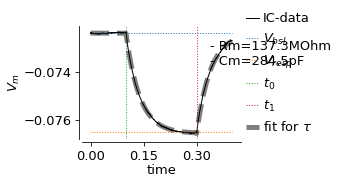

In [6]:
fit_passive_props(LoadICData(10), with_plot=True);

### Minimizing model parameters with respect to data

In [13]:
from data.exp_datasets import *
from data.Import import LoadICData
from datavyz import gen

import sys, os
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'cortical-physio-icm')) # append CPI to y
from electrophy.intracellular.passive_props import perform_ICcharact

def fit_passive_props(data, ax=None, with_plot=False):

    cond = (data['t']>600)
    t, v = data['t'][cond]-data['t'][cond][0], data['recordings'][data['Vrec_key']].mean(axis=0)[cond]
    if with_plot:
        return perform_ICcharact(1e-3*t, 1e-3*v,
                                 t0=IC_t0s[i]*1e-3, t1=(IC_t0s[i]+IC_dts[i])*1e-3,
                                 Istep=-30e-12, ax=ax, with_plot=True, ge=gen)
    else:
        return perform_ICcharact(1e-3*t, 1e-3*v, t0=IC_t0s[i]*1e-3, t1=(IC_t0s[i]+IC_dts[i])*1e-3,
                                   Istep=-30e-12, with_plot=False)

RMS, CMS = [], []
for i in range(len(IC_STEPS_DATASET)):
    data = LoadICData(i)
    Rm, Cm = fit_passive_props(data)
    RMS.append(Rm)
    CMS.append(Cm)

np.save(os.path.join('..', 'data','sims-results-passive-props-IC.npy'),
        {'RMS':RMS, 'CMS':CMS})

expRm = np.array(RMS).mean()
expCm = np.array(CMS).mean()
print('Rm=%.2f+/-%.2f MOhm,\nCm=%.2f+/-%.2f pF' % (1e-6*np.array(RMS).mean(),
                                                   1e-6*np.array(RMS).std(),
                                                   1e12*np.array(CMS).mean(),
                                                   1e12*np.array(CMS).std()))

Rm=137.53+/-50.16 MOhm,
Cm=208.06+/-42.96 pF


gL=0.29, cm=0.9, Ri=100.0


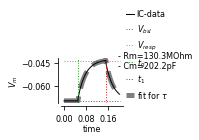

In [11]:
from analyz.IO.npz import load_dict
import sys, os
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'cortical-physio-icm')) # append CPI to y
from electrophy.intracellular.passive_props import perform_ICcharact

sim = GridSimulation(os.path.join('..', 'data', 'calib', 'passive-grid.npz'))
sim_results = {'Rm':np.zeros(sim.N), 'Cm':np.zeros(sim.N),
               'gL':np.zeros(sim.N), 'cm':np.zeros(sim.N),
               'residual':np.zeros(sim.N)}

# looping over simulations
for index in range(int(sim.N)):
    output = load_dict(os.path.join('..', 'data', 'calib', sim.params_filename(index)+'.npz'))
    Rm, Cm = perform_ICcharact(1e-3*output['t'],
                               1e-3*output['Vm_soma'],
                               t0=50e-3, t1=150e-3)
    sim_results['Rm'][index], sim_results['Cm'][index] = Rm, Cm
    D = {}
    sim.update_dict_from_GRID_and_index(index, D)
    sim_results['gL'][index], sim_results['cm'][index] = D['gL'], D['cm']
    sim_results['residual'][index] = (1+(Rm-expRm)**2/expRm**2)*(1+(Cm-expCm)**2/expCm**2)

# perform minimization
ibest = np.argmin(sim_results['residual'])

# show output
output = load_dict(os.path.join('..', 'data', 'calib', sim.params_filename(ibest)+'.npz'))
fig, ax, modelRm, modelCm = perform_ICcharact(1e-3*output['t'], 1e-3*output['Vm_soma'],
                                              t0=50e-3, t1=150e-3, with_plot=True, ge=ge)

# save results as default passive props
from model import Model
sim.update_dict_from_GRID_and_index(ibest, Model) # update Model parameters
print('gL=%.2f, cm=%.1f, Ri=%.1f' % (Model['gL'], Model['cm'], Model['Ri']))
np.save(os.path.join('..', 'data','passive-props-IC.npy'), {'gL':Model['gL'], 'cm':Model['cm'], 'filename':os.path.join('..', 'data', 'calib', sim.params_filename(ibest)+'.npz')})
np.save(os.path.join('..', 'data','sims-results-passive-props-IC.npy'), sim_results)

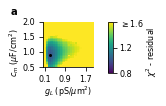

In [41]:
sim_results = np.load(os.path.join('..', 'data','sims-results-passive-props-IC.npy'),
                      allow_pickle=True).item()
from datavyz import ge
fig1, ax, acb = ge.twoD_plot(sim_results['gL'], sim_results['cm'],
                             sim_results['residual'],
                             vmin=0.8, vmax=1.6, colormap=ge.viridis,
                             bar_legend_args={'label':r'$\chi^2$ - residual    ',
                                              'ticks':[0.8, 1.2, 1.6]},
                             axes_args=dict(xlim_enhancement=0., ylim_enhancement=0., tck_outward=0,
                                            xlabel='$g_L$ (pS/$\mu$m$^2$)',
                                            xticks=[0.1, 0.9, 1.7],
                                            ylabel='$c_m$ ($\mu$F/cm$^2$)       '),
                             aspect='auto');
ge.scatter([Model['gL']], [Model['cm']], ax=ax, ms=2, no_set=True)
acb.set_ticklabels(['0.8', '1.2', '$\geq$1.6'])
ge.top_left_letter(ax, 'a', loc=(-.5,1.1), size='x-large')
#ge.savefig(fig11, 'figures/passive-props_grid.svg')

Rm=137.53+/-50.16 MOhm,
Cm=208.06+/-42.96 pF


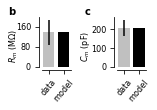

In [32]:
from datavyz import ge
fig2, AX = ge.figure(axes=(2,1), figsize=(0.6,1.1), wspace=2.5)

exp_passive = np.load(os.path.join('..', 'data','exp-passive-props-IC.npy'),
                      allow_pickle=True).item()
RMS, CMS =exp_passive['RMS'], exp_passive['CMS']

ge.bar([1e-6*np.array(RMS).mean()], sy=[1e-6*np.array(RMS).std()], width=0.75, ax=AX[0], no_set=True)
ge.bar(np.array([1e-6*np.array(RMS).mean()]), width=0.75, bins=[1], ax=AX[0], color='k', no_set=True)
ge.set_plot(AX[0], ylabel='$R_m$ (M$\Omega$)    ', ylabelpad=-4, xticks=[0,1],
            xticks_labels=['data','model'], xticks_rotation=50)

ge.bar([1e12*np.array(CMS).mean()], sy=[1e12*np.array(CMS).std()], width=0.75, ax=AX[1], no_set=True)
ge.bar(np.array([1e12*np.array(CMS).mean()]), width=0.75, bins=[1], ax=AX[1], color='k', no_set=True)
ge.set_plot(AX[1], ylabel='$C_m$ (pF)    ', ylabelpad=-1, xticks=[0,1],
            xticks_labels=['data','model'], xticks_rotation=50)
for l, ax in zip(['b', 'c'], AX):
    ge.top_left_letter(ax, l, loc=(-.9,1.), size='x-large')
#ge.savefig(fig12, 'figures/passive-props_values.svg')

In [53]:
cd C:\\Users\\yann.zerlaut\\work\\zinc-NMDA-modulation\\

C:\Users\yann.zerlaut\work\zinc-NMDA-modulation


In [56]:
from model import *
exp_passive = np.load(os.path.join('data','exp-passive-props-IC.npy'),
                      allow_pickle=True).item()
RMS, CMS =exp_passive['RMS'], exp_passive['CMS']
value = '$R_m$=%.1f$\pm$%.1f M$\Omega$, $C_m$=%.1f$\pm$%.1f pF (n=%i cells)' %\
    (1e-6*np.array(RMS).mean(),
     1e-6*np.array(RMS).std(),
     1e12*np.array(CMS).mean(),
     1e12*np.array(CMS).std(),
     len(CMS))

add_value_to_study_data('exp-passive-props', value, study='study.npy')

AttributeError: 'numpy.ndarray' object has no attribute 'files'

In [46]:
ge.multipanel_figure([[fig1, fig2]],
                     X=[[0, 180]], Y=[[-3, -8]],
                     width='one-and-a-half-column',
                     height=35,
                     export_to_png=True,
            fig_name=os.path.join('..', 'figures','passive-props.svg'))

RUNNING: inkscape ..\figures\passive-props.svg --export-area-page --export-background="white" --export-type=png --export-filename="..\figures\passive-props.png" --export-dpi=300
[ok] figure successfully exported as: ..\figures\passive-props.png
